In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors
import dask

In [251]:
sns.set(style = "whitegrid")

In [212]:
recipes = pd.read_csv('~/Datasets/food/RAW_recipes.csv')

In [213]:
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [214]:
recipes = recipes[0:round(recipes.shape[0]*0.25)]

# Exploration

In [215]:
def parse_ingredients(ingredients):
    ingredients = ingredients.replace("[", "").replace("]", "").replace("'", "")
    return ingredients.split(',')
recipes['ingredients_list'] = recipes.apply(lambda x: parse_ingredients(x['ingredients']), axis=1)

In [216]:
mlb = MultiLabelBinarizer()
df = pd.DataFrame(mlb.fit_transform(recipes['ingredients_list']),columns=mlb.classes_, index=recipes.index)

In [217]:
ingredient_list = list(df.columns)
sum_of_all_ingredients = pd.DataFrame(df[ingredient_list].sum(axis = 0)/df.shape[0], columns=['Percentage of times ingredient is in dataset'])

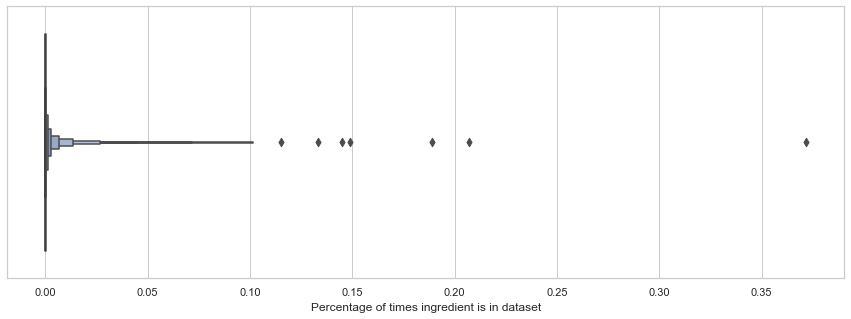

In [218]:
fig = plt.figure(figsize=(15, 5))
sns.set(style = "whitegrid")
n_ingredients_box_plot = sns.boxenplot(x = sum_of_all_ingredients["Percentage of times ingredient is in dataset"])
plt.show()

/Users/carla/opt/anaconda3/envs/smartfoodjournal/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='minutes', ylabel='Density'>

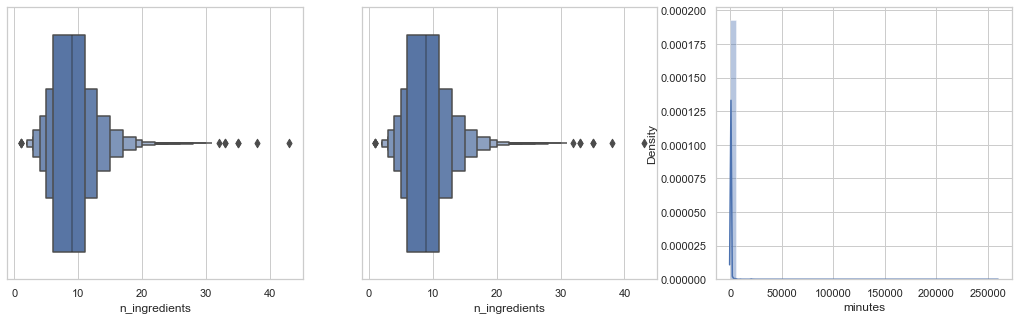

In [253]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
for i, col in enumerate(['n_ingredients', 'n_steps']):
    sns.boxenplot(x = recipes['n_ingredients'], ax=ax[i])
sns.distplot(recipes['minutes'], ax=ax[2])

In [222]:
nutrition_columns = ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbs']

In [230]:
def get_nutrition_values(x, nutrition_idx):
    nutrition = x.replace('[', '').replace(']', '').split(',')
    return float(nutrition[nutrition_idx])

for idx, column in enumerate(nutrition_columns):
    recipes[column]= recipes['nutrition'].apply(get_nutrition_values, nutrition_idx=idx)

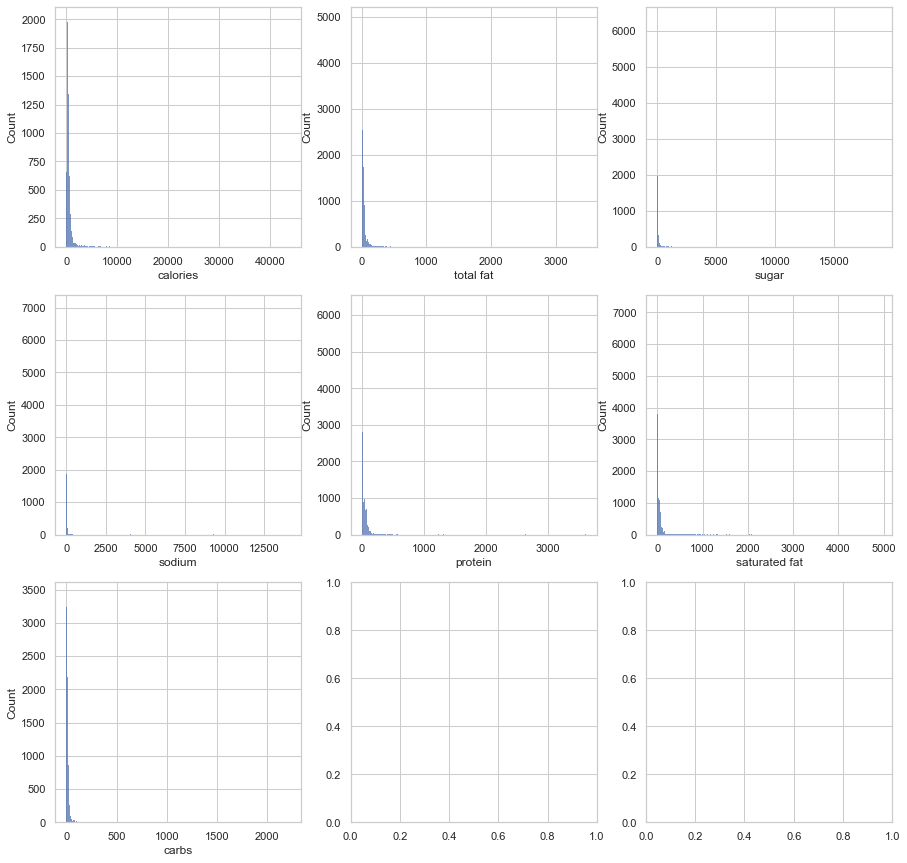

In [255]:
fig, ax = plt.subplots(3,3,figsize=(15,15))
start = 0
end = 3
for i in range(0,3):
    for j, column in enumerate(nutrition_columns[start:end]):
        sns.histplot(x=recipes[column],ax=ax[i][j])
    start+=3
    end+=3

 # Cleaning

In [38]:
final_ingredients_list = sum_of_all_ingredients[sum_of_all_ingredients['Percentage of times ingredient is in dataset']>0.01]

In [50]:
df = df.loc[:,list(final_ingredients_list.index)]

## Inference

In [90]:
MAPPING = pd.Series(df.index, index=recipes.name.values)

In [144]:
def get_nearest_neighbour_recipe(recipe_embedding, nn_model):
    return nn.kneighbors(recipe_embedding, return_distance=False)
def get_recipe_embedding(recipe_name):
    recipe_idx = MAPPING[recipe_name]
    return df.iloc[recipe_idx,:].values.reshape(1, -1)

In [150]:
nn = NearestNeighbors(n_neighbors=3)
nn.fit(df.values)
recipe_embedding = get_recipe_embedding('corkscrew pasta with shrimp  sugar snap peas  and red peppers')
print(get_nearest_neighbour_recipe(recipe_embedding, nn))

[[57907 42180 11997]]


In [155]:
print(recipes.iloc[42180,:].ingredients)
print(' ')
print(recipes.iloc[57907,:].ingredients)

['plain low-fat yogurt', 'dijon mustard', 'fresh chives', 'boneless skinless chicken breast halves', 'fresh basil', 'garlic', 'salt', 'pepper', 'italian breadcrumbs', 'romano cheese']
 
['rotini pasta', 'sugar snap pea', 'extra virgin olive oil', 'garlic', 'medium shrimp', 'salt', 'pepper', 'red pepper', 'fresh basil', 'lemon juice', 'lemons, zest of', 'dijon mustard']


## Ranking